In [110]:
from google.colab import drive 
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from keras import optimizers
from keras import layers
from keras import models
from keras import initializers

import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import backend as K


base_dir = r'/content/gdrive/My Drive/MVP Datensatz/'
train_dir = r'/content/gdrive/My Drive/MVP Datensatz/Trainingsdatensatz5'


In [112]:
## create base_model

from keras.applications import Xception
base_model = Xception(
  weights = 'imagenet',
  include_top = False,
  input_shape = (299,299,3) # default vaules 
 )

base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [128]:
## create train and validation generators

batch_s = 30  # global batch_size
img_width = 299
img_height = 299

## Train und Vaild Splitting

# Beispiel für mögliche Data Augmentations
train_datagen = ImageDataGenerator(
                          featurewise_center = False,
                          samplewise_center = False,
                          featurewise_std_normalization = False,
                          samplewise_std_normalization = False,
                          rotation_range = 359,
                          width_shift_range = 30.0,
                          height_shift_range = 0.0,
                          brightness_range = None,
                          channel_shift_range = 50.0,
                          horizontal_flip = True, 
                          vertical_flip = True, 
                          rescale = 1./255,
                          validation_split = 0.2, 
                          interpolation_order = 1, 
                          dtype = 'float32'
                          )

valid_datagen = ImageDataGenerator(
                          rescale=1./255,
                          validation_split=0.2
                          )

train_generator = train_datagen.flow_from_directory(
                          train_dir, 
                          target_size = (img_width,img_height),
                          batch_size = batch_s,
                          class_mode = 'categorical',
                          subset = 'training'
                          )

validation_generator = train_datagen.flow_from_directory(
                          train_dir, 
                          target_size = (img_width,img_height),
                          batch_size = batch_s,
                          class_mode = 'categorical',
                          subset = 'validation'
                          )           

Found 113 images belonging to 5 classes.
Found 25 images belonging to 5 classes.


In [129]:
## create model

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation = 'relu', kernel_initializer = initializers.RandomNormal(stddev = 0.01), bias_initializer = initializers.Zeros()))
model.add(layers.Dense(5, activation = 'sigmoid', kernel_initializer = initializers.RandomNormal(stddev = 0.01), bias_initializer = initializers.Zeros()))
# freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False

model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
flatten_18 (Flatten)         (None, 204800)            0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 204800)            0         
_________________________________________________________________
dense_44 (Dense)             (None, 256)               52429056  
_________________________________________________________________
dense_45 (Dense)             (None, 5)                 1285      
Total params: 73,291,821
Trainable params: 52,430,341
Non-trainable params: 20,861,480
_________________________________________________________________


Epoch 1/20
4/4 [==============================] - 9s 2s/step - loss: 1.3805 - acc: 0.2035 - val_loss: 1.8373 - val_acc: 0.2000
Epoch 2/20
4/4 [==============================] - 4s 887ms/step - loss: 1.2778 - acc: 0.2389 - val_loss: 1.5308 - val_acc: 0.4400
Epoch 3/20
4/4 [==============================] - 5s 1s/step - loss: 1.2494 - acc: 0.3540 - val_loss: 1.2911 - val_acc: 0.2800
Epoch 4/20
4/4 [==============================] - 5s 1s/step - loss: 1.1991 - acc: 0.4336 - val_loss: 1.6675 - val_acc: 0.6000
Epoch 5/20
4/4 [==============================] - 5s 1s/step - loss: 1.2779 - acc: 0.5133 - val_loss: 2.9936 - val_acc: 0.4400
Epoch 6/20
4/4 [==============================] - 5s 1s/step - loss: 1.3005 - acc: 0.4867 - val_loss: 2.8482 - val_acc: 0.4000
Epoch 7/20
4/4 [==============================] - 5s 1s/step - loss: 1.0753 - acc: 0.4248 - val_loss: 2.3646 - val_acc: 0.3200
Epoch 8/20
4/4 [==============================] - 5s 1s/step - loss: 0.9631 - acc: 0.4602 - val_loss: 1.8722

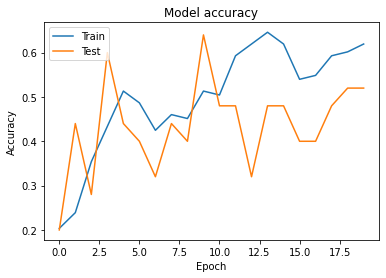

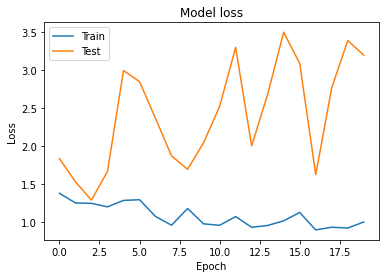

In [131]:
# first: train only the top layers (which were randomly initialized)
opt = optimizers.Adam(learning_rate=0.0009)
epochs = 20
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
history = model.fit_generator(
                    train_generator,
                    epochs = epochs,
                    validation_data = validation_generator
                    )

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
model.save("/content/gdrive/My Drive/Keras Models/Xception_5-1.h5")


In [133]:
# image folder
folder_path = base_dir + 'Testbilder/'
# path to model
model_path = '/path/to/saved/model.h5'


# load all images into a list
images = []
for img in os.listdir(folder_path):
    img = os.path.join(folder_path, img)
    img = image.load_img(img, target_size=(img_width, img_height))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images.append(img)

# stack up images list to pass for prediction
images = np.vstack(images)
classes = model.predict_classes(images)
print(classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [0]:
import json
def Vorhersage(Artikelfoto, Speicherort_KI_Modell, Name_KI_Modell):

    model = models.load_model(Speicherort_KI_Modell + Name_KI_Modell)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
    Artikelfoto = image.load_img(Artikelfoto, target_size=(img_width, img_height))
    Artikelfoto = image.img_to_array(Artikelfoto)
    Artikelfoto = np.expand_dims(Artikelfoto, axis=0)
    prediction = model.predict(Artikelfoto)
    prediction = prediction.flatten()
    artikelnummer = 'Art' + str(np.argmax(prediction)+1)
    wahrscheinlichkeit = str(prediction[np.argmax(prediction)])

    response = json.dumps({"Artikelnummer":artikelnummer, "Wahrscheinlichkeit":wahrscheinlichkeit})

    return response

In [134]:
Vorhersage(base_dir + 'Testbilder/P1040695.JPG', '/content/gdrive/My Drive/Keras Models', '/Xception_5-1.h5')

'{"Artikelnummer": "Art1", "Wahrscheinlichkeit": "0.0"}'